In [ ]:
!pip install --upgrade xgboost  # Upgrade XGBoost
import xgboost
print(xgboost.__version__)  # Confirm the version

2.1.4


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold # Import StratifiedKFold here
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler # Import StandardScaler here
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, roc_auc_score # Import roc_auc_score here
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score # Import cross_val_score here
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the file path and load
file_path = '/content/drive/My Drive/Colab Notebooks/DAT 490 CAPSTONE/DataCoSupplyChainDatasetRefined.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
irrelevant_columns = ["customer_email", "customer_password", "product_image"]
df = df.drop(columns=irrelevant_columns, errors='ignore')

In [ ]:
df.customer_lname.fillna(value="", inplace=True)
df.dropna(subset=['customer_zipcode'], inplace=True)
df.dropna(axis=1, inplace=True)

<ipython-input-5-25cfe8cef341>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.customer_lname.fillna(value="", inplace=True)


In [ ]:
date_columns = ["order_date_dateorders", "shipping_date_dateorders"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['order_day_of_week'] = df['order_date_dateorders'].dt.dayofweek
df['shipping_day_of_week']= df['shipping_date_dateorders'].dt.dayofweek
df['shipping_delay'] = df.days_for_shipping_real - df.days_for_shipment_scheduled

df.drop(columns=date_columns, inplace=True)

In [ ]:
useful_cat_cols = ['type', 'customer_segment']
df = pd.get_dummies(df, columns=useful_cat_cols, dtype=int)

In [ ]:
# Standardising the column names again after encoding
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_').str.replace(r'[()]', '', regex=True)
df.filter(regex='*|'.join(useful_cat_cols)).head()

,type_cash,type_debit,type_payment,type_transfer,customer_segment_consumer,customer_segment_corporate,customer_segment_home_office
0,0,1,0,0,1,0,0
1,0,0,0,1,1,0,0
2,1,0,0,0,1,0,0
3,0,1,0,0,0,0,1
4,0,0,1,0,0,1,0


In [ ]:
shipping_priority = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
shipping_mapping = {mode: idx for idx, mode in enumerate(shipping_priority)}

df.shipping_mode = df.shipping_mode.map(shipping_mapping)

In [ ]:
quantitative_columns = [
    'benefit_per_order', 'days_for_shipping_real', 'days_for_shipment_scheduled',
    'sales_per_customer', 'order_item_discount', 'order_item_product_price',
    'order_item_profit_ratio', 'order_item_quantity', 'sales',
    'order_item_total', 'order_profit_per_order', 'product_price'
]

scaler = StandardScaler()
df[quantitative_columns] = scaler.fit_transform(df[quantitative_columns])

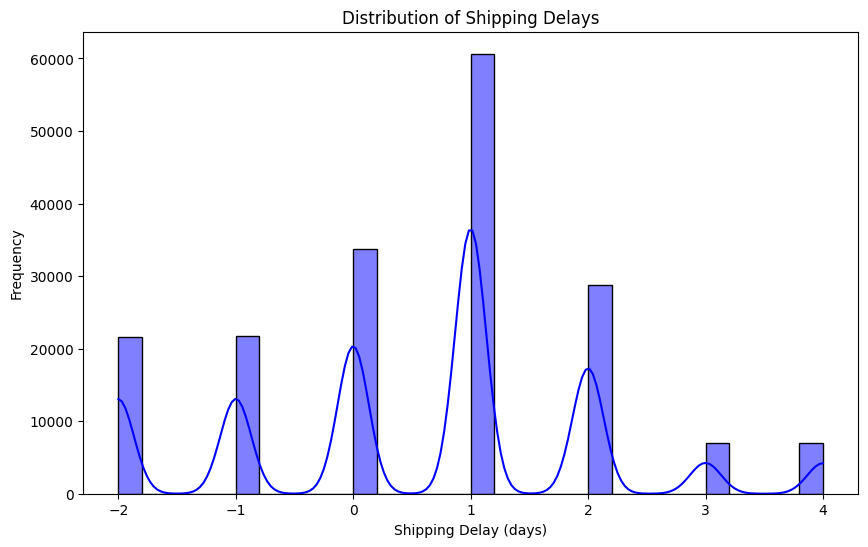

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['shipping_delay'], bins=30, kde=True, color='blue')
plt.title("Distribution of Shipping Delays")
plt.xlabel("Shipping Delay (days)")
plt.ylabel("Frequency");

In [ ]:
target = df['late_delivery_risk']

useless_num = [
    'category_id', 'customer_id', 'customer_zipcode', 'department_id',
    'order_id', 'order_item_cardprod_id', 'order_item_id', 'order_customer_id',
    'product_card_id', 'product_category_id', 'product_status',
    'latitude_src', 'longitude_src', 'latitude_dest', 'longitude_dest'
]

useless_cat = [
    'category_name', 'customer_city', 'customer_country', 'customer_fname',
    'customer_lname','customer_state', 'customer_street',
    'order_status', 'order_region', 'order_state', 'order_city', 'order_country',
    'product_name', 'department_name', 'market', 'delivery_status', 'address_dest',
    'order_country_en', 'order_state_en', 'order_city_en'
]

useless_features = useless_cat + useless_num

features = df.drop(columns=['late_delivery_risk']+useless_features, errors='ignore')
print(features.shape)

(180516, 24)


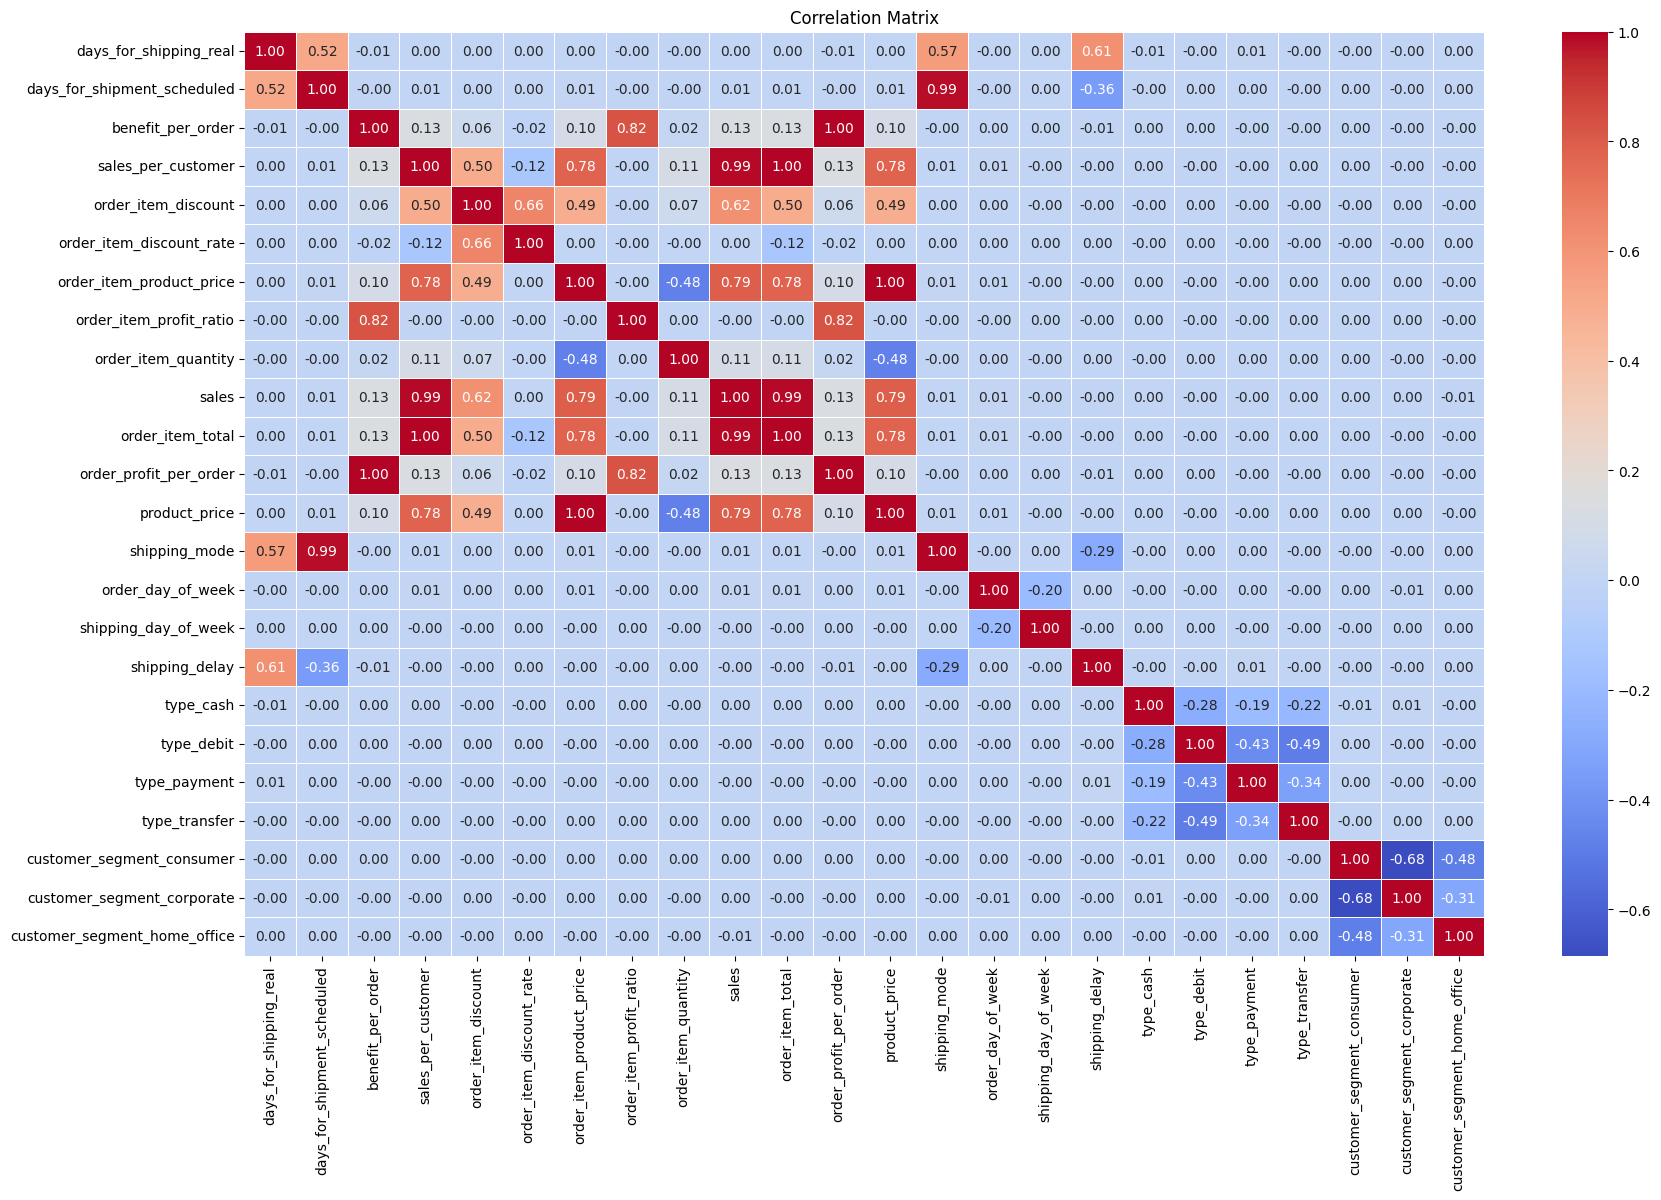

In [ ]:
correlation_matrix = features.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
features.drop(columns=[
    'shipping_delay',
    'days_for_shipping_real',
    'shipping_mode',
    'benefit_per_order',
    'sales_per_customer',
    'order_item_total',
    'order_item_product_price',
], inplace=True, errors='ignore')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

<ipython-input-16-cc1ea1187dc4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_distribution.index, y=target_distribution.values, palette='viridis')


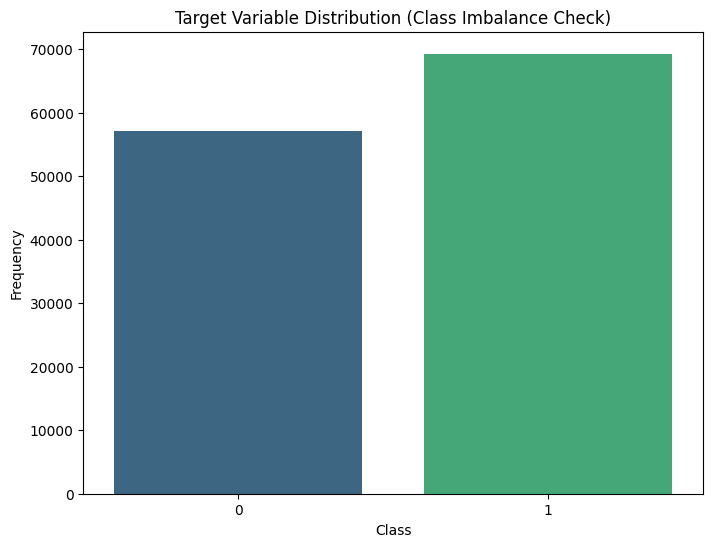

Target Variable Class Distribution:
late_delivery_risk
1    69283
0    57078
Name: count, dtype: int64


In [ ]:
target_distribution = y_train.value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=target_distribution.index, y=target_distribution.values, palette='viridis')
plt.title('Target Variable Distribution (Class Imbalance Check)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

print("Target Variable Class Distribution:")
print(target_distribution)


Random Forest Model Performance:
Accuracy: 0.9569
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95     24462
           1       0.94      0.98      0.96     29693

    accuracy                           0.96     54155
   macro avg       0.96      0.95      0.96     54155
weighted avg       0.96      0.96      0.96     54155



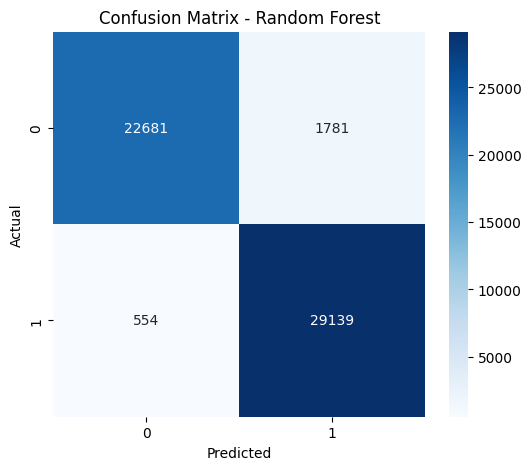


Logistic Regression Model Performance:
Accuracy: 0.6907
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.82      0.70     24462
           1       0.80      0.59      0.68     29693

    accuracy                           0.69     54155
   macro avg       0.71      0.70      0.69     54155
weighted avg       0.72      0.69      0.69     54155



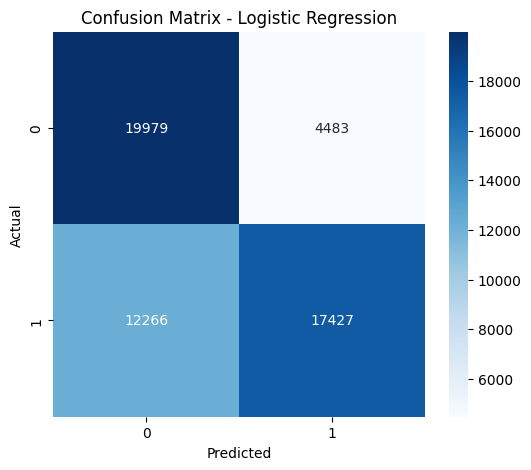

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:32:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Model Performance:
Accuracy: 0.9752
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     24462
           1       0.96      1.00      0.98     29693

    accuracy                           0.98     54155
   macro avg       0.98      0.97      0.97     54155
weighted avg       0.98      0.98      0.98     54155



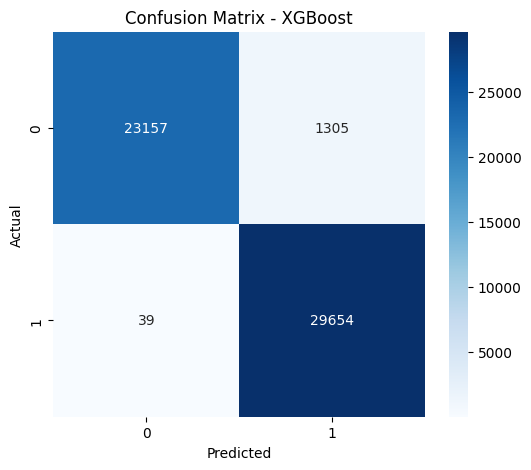


K-Nearest Neighbors Model Performance:
Accuracy: 0.9438
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     24462
           1       0.92      0.98      0.95     29693

    accuracy                           0.94     54155
   macro avg       0.95      0.94      0.94     54155
weighted avg       0.95      0.94      0.94     54155



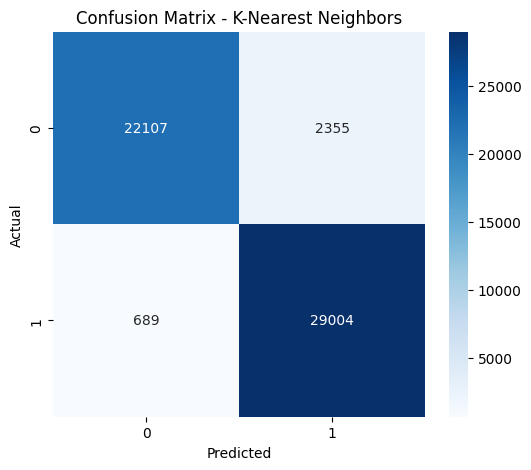

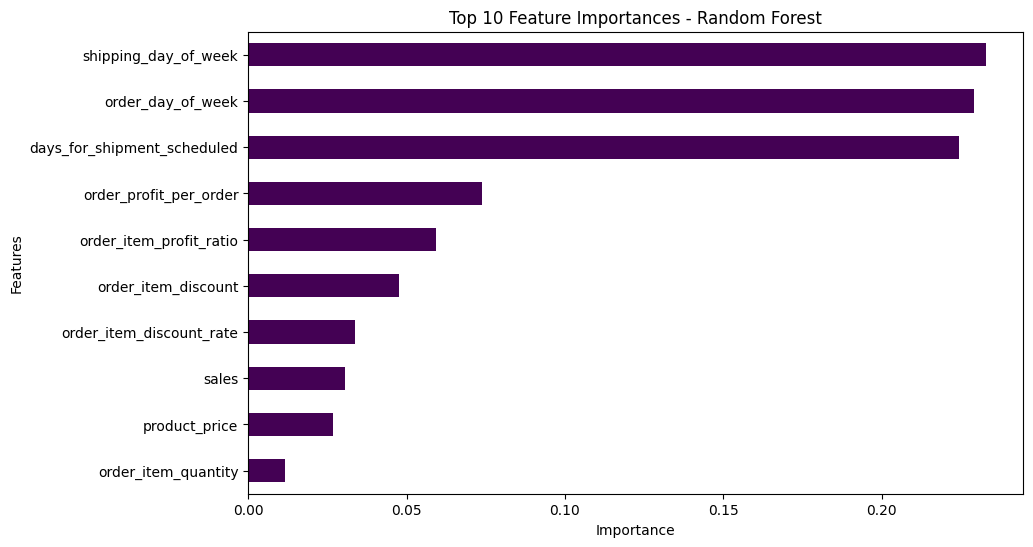

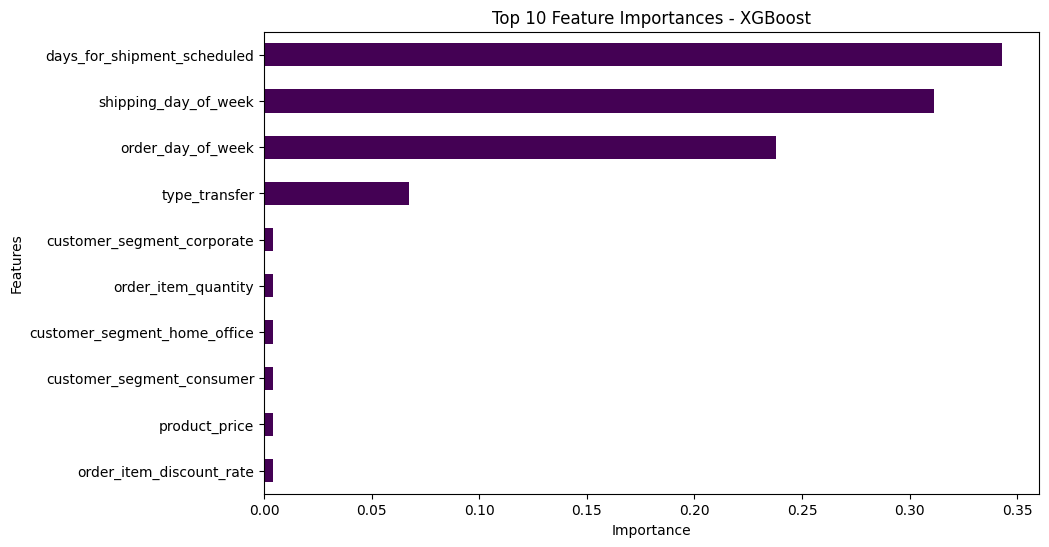

In [ ]:

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"\n{name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Feature Importance for Random Forest and XGBoost
for name, model in models.items():
    if name in ["Random Forest", "XGBoost"]:
        feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
        feature_importances.nlargest(10).sort_values().plot(kind='barh', figsize=(10, 6), colormap='viridis')
        plt.title(f"Top 10 Feature Importances - {name}")
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.show()


THIS IS THE POINT WHERE WE TUNE / REFER TO NOTES FOR HYPERPARAMETER CODE THAT WAS DELETED

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:34:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Accuracy: 0.9568645554427108
XGBoost Accuracy: 0.9757363124365248


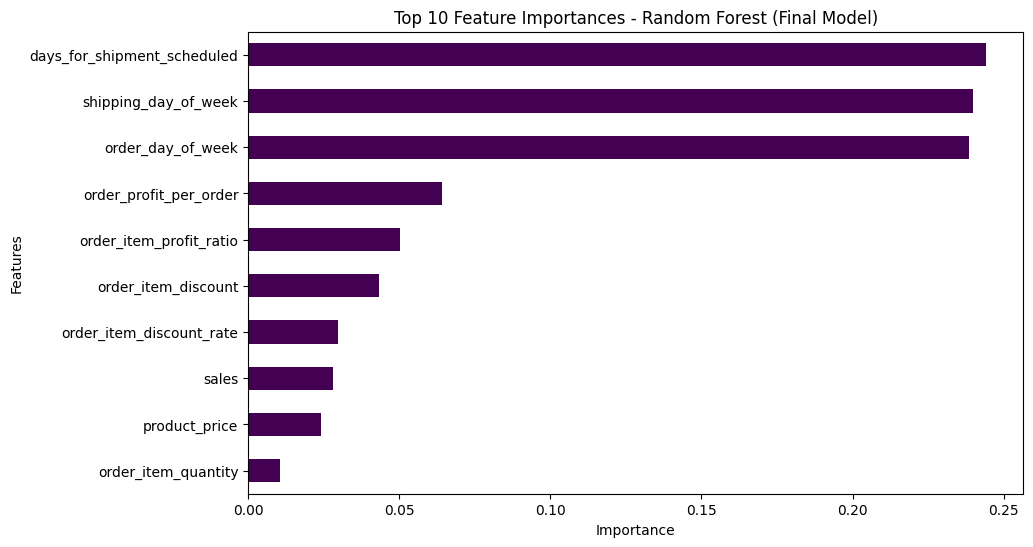

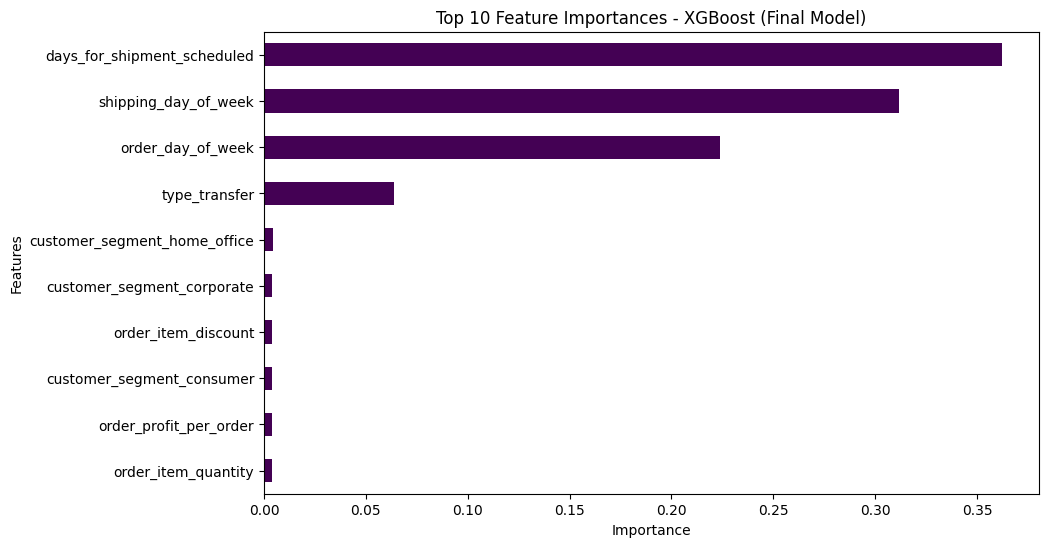

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Use Best Parameters Directly (Skipping Tuning)
best_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=5,
    max_depth=None,
    random_state=42
)
best_rf.fit(X_train, y_train)

best_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
best_xgb.fit(X_train, y_train)

# Print Model Accuracy
print("Random Forest Accuracy:", best_rf.score(X_test, y_test))
print("XGBoost Accuracy:", best_xgb.score(X_test, y_test))

# Feature Importance Analysis
for name, model in {"Random Forest": best_rf, "XGBoost": best_xgb}.items():
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feature_importances.nlargest(10).sort_values().plot(kind='barh', figsize=(10, 6), colormap='viridis')
    plt.title(f"Top 10 Feature Importances - {name} (Final Model)")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

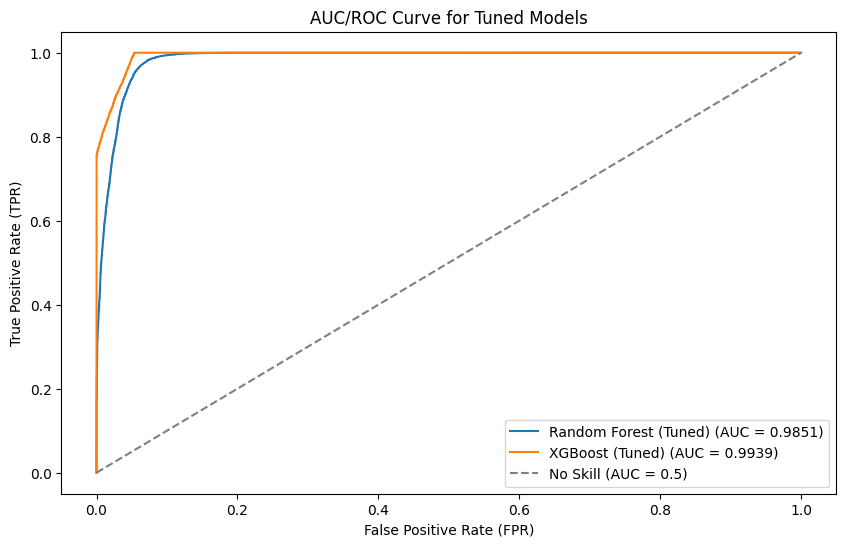

In [ ]:
from sklearn.metrics import roc_curve, auc

# Function to plot AUC/ROC curve
def plot_auc_roc(model, X_test, y_test, model_name):
    y_probs = model.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})")

# Plot ROC curves for both tuned models
plt.figure(figsize=(10, 6))
plot_auc_roc(best_rf, X_test, y_test, "Random Forest (Tuned)")
plot_auc_roc(best_xgb, X_test, y_test, "XGBoost (Tuned)")

# Plot the reference "no skill" classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="No Skill (AUC = 0.5)")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("AUC/ROC Curve for Tuned Models")
plt.legend()
plt.show()

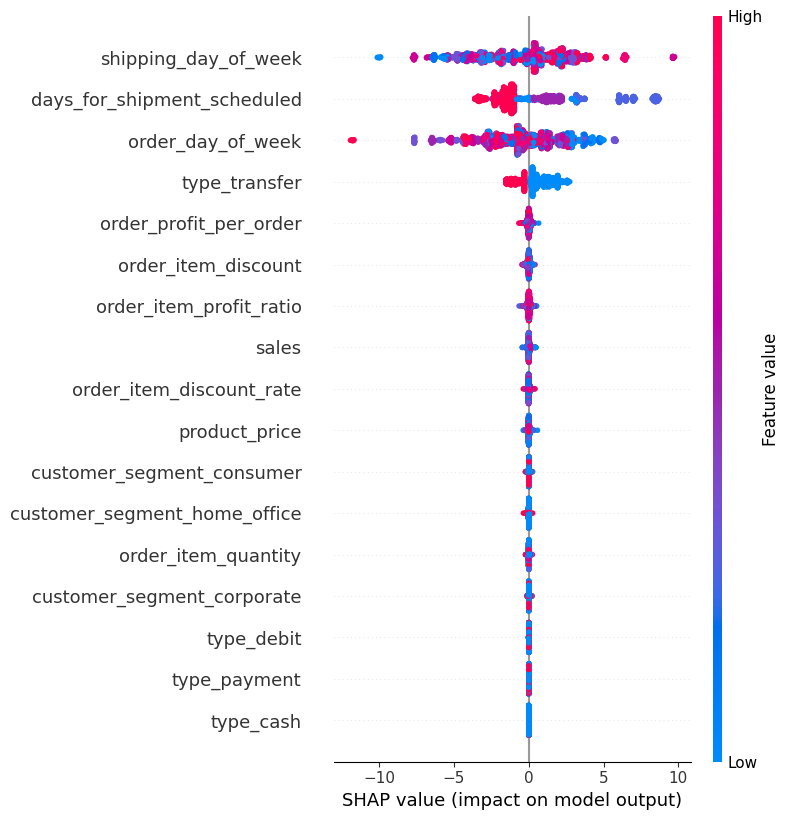

In [ ]:
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test[:2000], approximate=True)  # Limit to 2,000 rows

shap.summary_plot(shap_values, X_test[:2000])  # Plot only for limited data

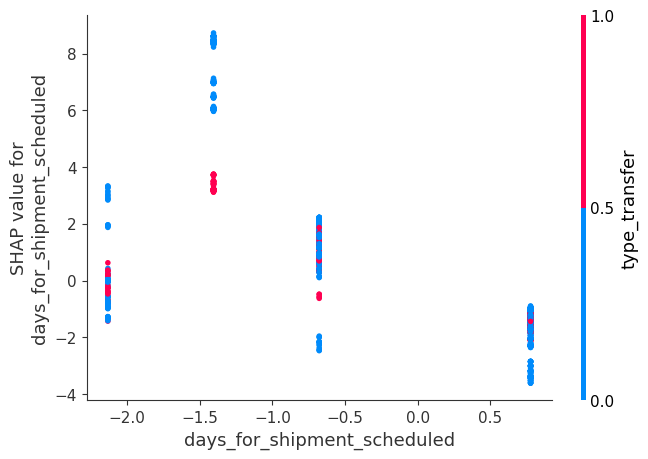

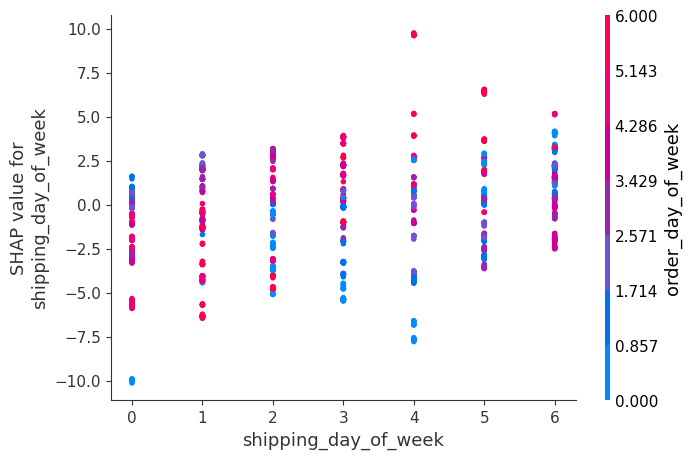

In [ ]:
# Ensure X_test is limited to the same size as shap_values
X_test_sample = X_test[:2000]

shap.dependence_plot("days_for_shipment_scheduled", shap_values, X_test_sample)
shap.dependence_plot("shipping_day_of_week", shap_values, X_test_sample)